Do some visualization on the data we recieve:




Average time difference:  0.010046808090320053


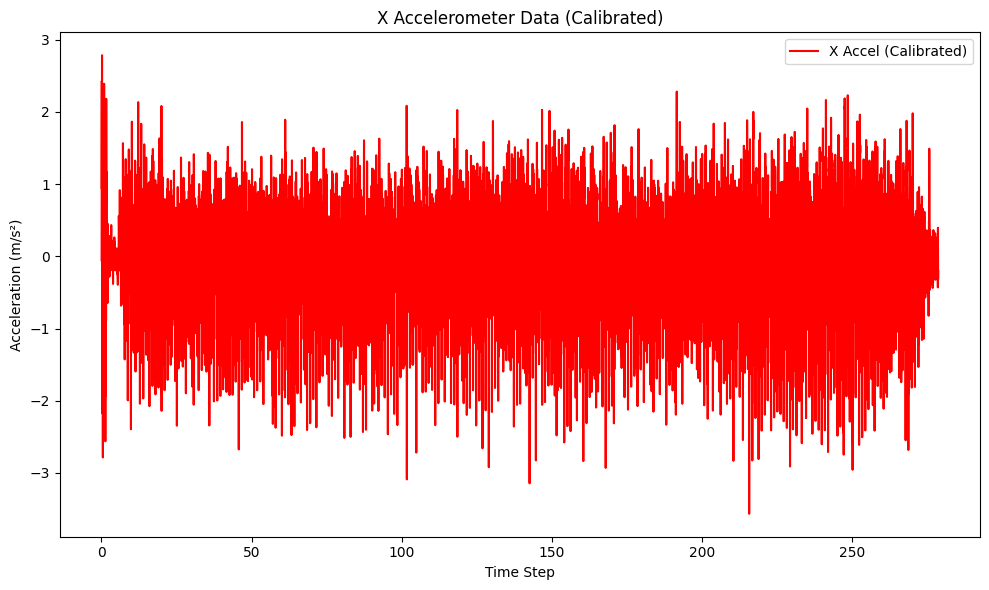

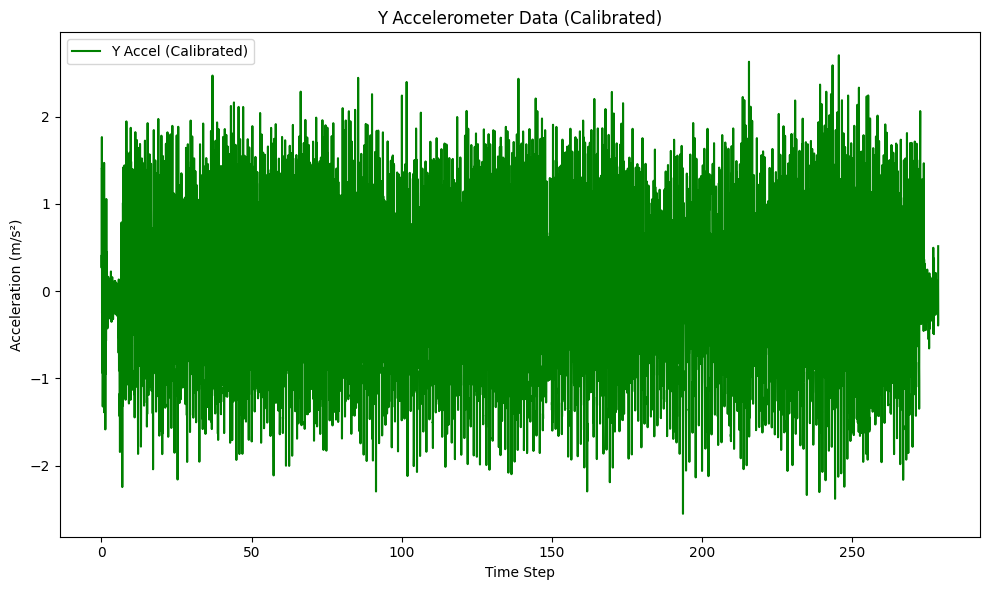

In [32]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the calibrated accelerometer data
calibratedaccel = pd.read_csv('Accelerometer.csv')

# Extracting timesteps and accelerometer data for x and y axes
timesteps = calibratedaccel.iloc[:, 1]
xaccelcalib = calibratedaccel.iloc[:, 4]
yaccelcalib = calibratedaccel.iloc[:, 3]

# Compute the time differences
differences = timesteps.diff().dropna()

# Compute the average time difference
average_difference = differences.mean()
print("Average time difference: ", average_difference)

# Plotting the X Acceleration data
plt.figure(figsize=(10, 6))
plt.plot(timesteps, xaccelcalib, label='X Accel (Calibrated)', color='r')
plt.xlabel('Time Step')
plt.ylabel('Acceleration (m/s²)')
plt.title('X Accelerometer Data (Calibrated)')
plt.legend()
plt.tight_layout()
plt.show()

# Plotting the Y Acceleration data
plt.figure(figsize=(10, 6))
plt.plot(timesteps, yaccelcalib, label='Y Accel (Calibrated)', color='g')
plt.xlabel('Time Step')
plt.ylabel('Acceleration (m/s²)')
plt.title('Y Accelerometer Data (Calibrated)')
plt.legend()
plt.tight_layout()
plt.show()


0       -0.055416
1        0.095232
2        0.092118
3        0.628266
4        1.137043
           ...   
27716   -0.023616
27717    0.080926
27718   -0.056039
27719   -0.318254
27720   -0.207567
Name: x, Length: 27721, dtype: float64
[[-0.05347161  0.3890027 ]
 [ 0.06192722  0.29459735]
 [ 0.0850576   0.44333888]
 ...
 [-0.02973241 -0.33475531]
 [-0.25061398 -0.32348816]
 [-0.21765878  0.31817317]]


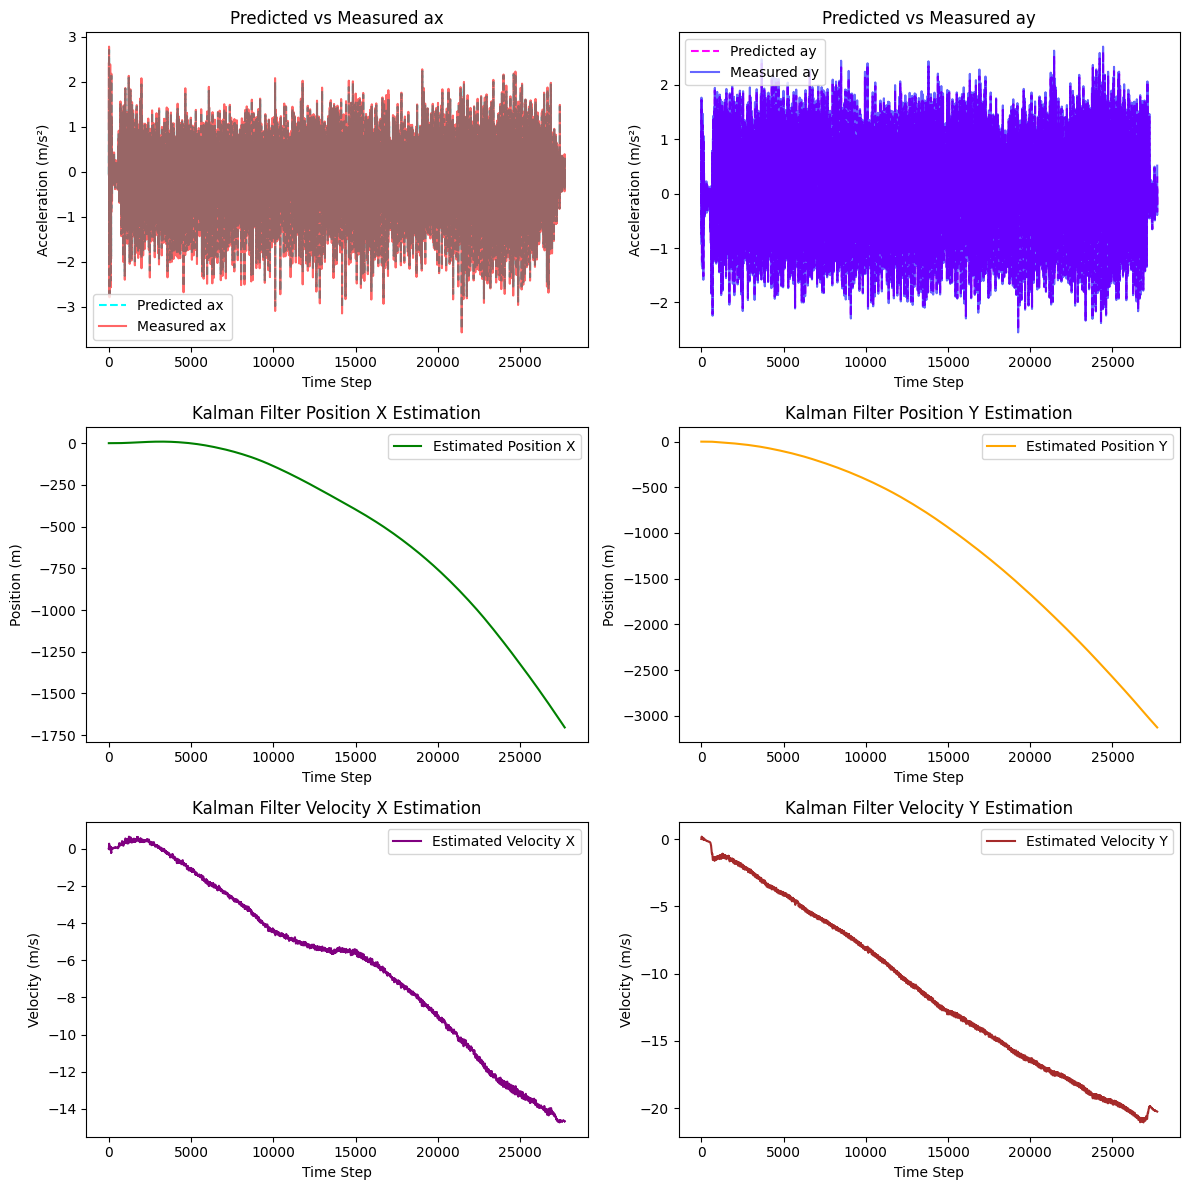

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

class KalmanFilter(object):
    def __init__(self, F = None, B = None, H = None, Q = None, R = None, P = None, x0 = None):

        if(F is None or H is None):
            raise ValueError("Set proper system dynamics.")

        self.n = F.shape[1]
        self.m = H.shape[1]

        self.F = F
        self.H = H
        self.B = 0 if B is None else B
        self.Q = np.eye(self.n) if Q is None else Q
        self.R = np.eye(self.n) if R is None else R
        self.P = np.eye(self.n) if P is None else P
        self.x = np.zeros((self.n, 1)) if x0 is None else x0

    def predict(self, u = 0):
        self.x = np.dot(self.F, self.x) + np.dot(self.B, u)
        self.P = np.dot(np.dot(self.F, self.P), self.F.T) + self.Q
        return self.x

    def update(self, z):
        y = z - np.dot(self.H, self.x)
        S = self.R + np.dot(self.H, np.dot(self.P, self.H.T))
        K = np.dot(np.dot(self.P, self.H.T), np.linalg.inv(S))
        self.x = self.x + np.dot(K, y)
        I = np.eye(self.n)
        self.P = np.dot(np.dot(I - np.dot(K, self.H), self.P), 
        	(I - np.dot(K, self.H)).T) + np.dot(np.dot(K, self.R), K.T)

        
def example():
    # Time step
    delta_t = average_difference

    # State transition matrix
    F = np.array([
        [1, 0, delta_t, 0, 0.5 * delta_t**2, 0],
        [0, 1, 0, delta_t, 0, 0.5 * delta_t**2],
        [0, 0, 1, 0, delta_t, 0],
        [0, 0, 0, 1, 0, delta_t],
        [0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 1]
    ])
    
    # Observation matrix (for acceleration-only measurement)
    H = np.array([
        [0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 1]
    ])

    # Process noise covariance
    Q = np.array([
        [0.001, 0, 0, 0, 0, 0],
        [0, 0.001, 0, 0, 0, 0],
        [0, 0, 0.01, 0, 0, 0],
        [0, 0, 0, 0.01, 0, 0],
        [0, 0, 0, 0, 0.1, 0],
        [0, 0, 0, 0, 0, 0.1]
    ])

    # Measurement noise covariance
    R = np.array([
        [0.04, 0],
        [0, 0.04]
    ])
    
    x0 = np.zeros((6, 1))

    # Read CSV data (before Steven's data)
    #measurements = df[['ax', 'ay']].to_numpy()

    #new datafile after Steven's data:
    measurements = calibratedaccel[['x', 'y']].to_numpy()

    # Initialize Kalman Filter
    kf = KalmanFilter(F=F, H=H, Q=Q, R=R, x0=x0)

    # Lists for storing predictions and measurements
    acceleration_estimates = []
    position_estimates = []
    velocity_estimates = []
    measured_accel_x = measurements[:, 0]  # Measured x acceleration
    measured_accel_y = measurements[:, 1]  # Measured y acceleration

    # Loop for the length of the accelerometer data
    for z in measurements:
        z = z.reshape(2, 1)
        kf.predict()
        kf.update(z)

        # Extracting acceleration, velocity, and position estimates
        acceleration_estimates.append(kf.x[4:6].flatten())
        position_estimates.append(kf.x[0:2].flatten())
        velocity_estimates.append(kf.x[2:4].flatten())

    acceleration_estimates = np.array(acceleration_estimates)
    position_estimates = np.array(position_estimates)
    velocity_estimates = np.array(velocity_estimates)    

    # Plotting acceleration estimates and measurements for X and Y components
    plt.figure(figsize=(12, 12))

    # Plotting predicted vs. measured ax
    plt.subplot(3, 2, 1)
    plt.plot(range(len(acceleration_estimates)), acceleration_estimates[:, 0], '--', label='Predicted ax', color='cyan')
    plt.plot(range(len(measured_accel_x)), xaccelcalib, label='Measured ax', color='red', alpha=0.6)
    plt.xlabel('Time Step')
    plt.ylabel('Acceleration (m/s²)')
    plt.legend()
    plt.title('Predicted vs Measured ax')

    print(xaccelcalib)
    print(acceleration_estimates)

    # Plotting predicted vs. measured ay
    plt.subplot(3, 2, 2)
    plt.plot(range(len(acceleration_estimates)), acceleration_estimates[:, 1], '--', label='Predicted ay', color='magenta')
    plt.plot(range(len(measured_accel_y)), yaccelcalib, label='Measured ay', color='blue', alpha=0.6)
    plt.xlabel('Time Step')
    plt.ylabel('Acceleration (m/s²)')
    plt.legend()
    plt.title('Predicted vs Measured ay')

    # Plotting estimated Position X
    plt.subplot(3, 2, 3)
    plt.plot(range(len(position_estimates)), position_estimates[:, 0], label='Estimated Position X', color='green')
    plt.xlabel('Time Step')
    plt.ylabel('Position (m)')
    plt.legend()
    plt.title('Kalman Filter Position X Estimation')

    # Plotting estimated Position Y
    plt.subplot(3, 2, 4)
    plt.plot(range(len(position_estimates)), position_estimates[:, 1], label='Estimated Position Y', color='orange')
    plt.xlabel('Time Step')
    plt.ylabel('Position (m)')
    plt.legend()
    plt.title('Kalman Filter Position Y Estimation')

    # Plotting estimated Velocity X
    plt.subplot(3, 2, 5)
    plt.plot(range(len(velocity_estimates)), velocity_estimates[:, 0], label='Estimated Velocity X', color='purple')
    plt.xlabel('Time Step')
    plt.ylabel('Velocity (m/s)')
    plt.legend()
    plt.title('Kalman Filter Velocity X Estimation')

    # Plotting estimated Velocity Y
    plt.subplot(3, 2, 6)
    plt.plot(range(len(velocity_estimates)), velocity_estimates[:, 1], label='Estimated Velocity Y', color='brown')
    plt.xlabel('Time Step')
    plt.ylabel('Velocity (m/s)')
    plt.legend()
    plt.title('Kalman Filter Velocity Y Estimation')

    plt.tight_layout()
    plt.show()

    print()

if __name__ == '__main__':
    example()
